<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Imports" data-toc-modified-id="Data-Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Imports</a></span></li><li><span><a href="#Data-Examination" data-toc-modified-id="Data-Examination-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Examination</a></span></li><li><span><a href="#Network-implementation" data-toc-modified-id="Network-implementation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Network implementation</a></span></li></ul></div>

# Bird Classifier

Built using the Kaggle sourced <a href=https://www.kaggle.com/datasets/gpiosenka/100-bird-species>dataset</a> of 525 bird species.

## Data Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import datasets, transforms

In [2]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [3]:
batch_size = 16

In [4]:
data_dir = '/media/metal_undivided/DATA/Datasets/Kaggle_525_species/'

train_dataset = datasets.ImageFolder(data_dir + 'train/', transform=transform)
val_dataset = datasets.ImageFolder(data_dir + 'valid/', transform=transform)
test_dataset = datasets.ImageFolder(data_dir + 'test/', transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [5]:
#next(iter(train_dataloader))[0]

The data is successfully imported, let's examine it.

## Data Examination

In [6]:
pixels, labels = next(iter(train_dataloader))

Let's also get the label-species pairs for visualisation.

In [7]:
species = train_dataset.find_classes(data_dir + 'train/')
species = {label:name for name, label in species[1].items()}

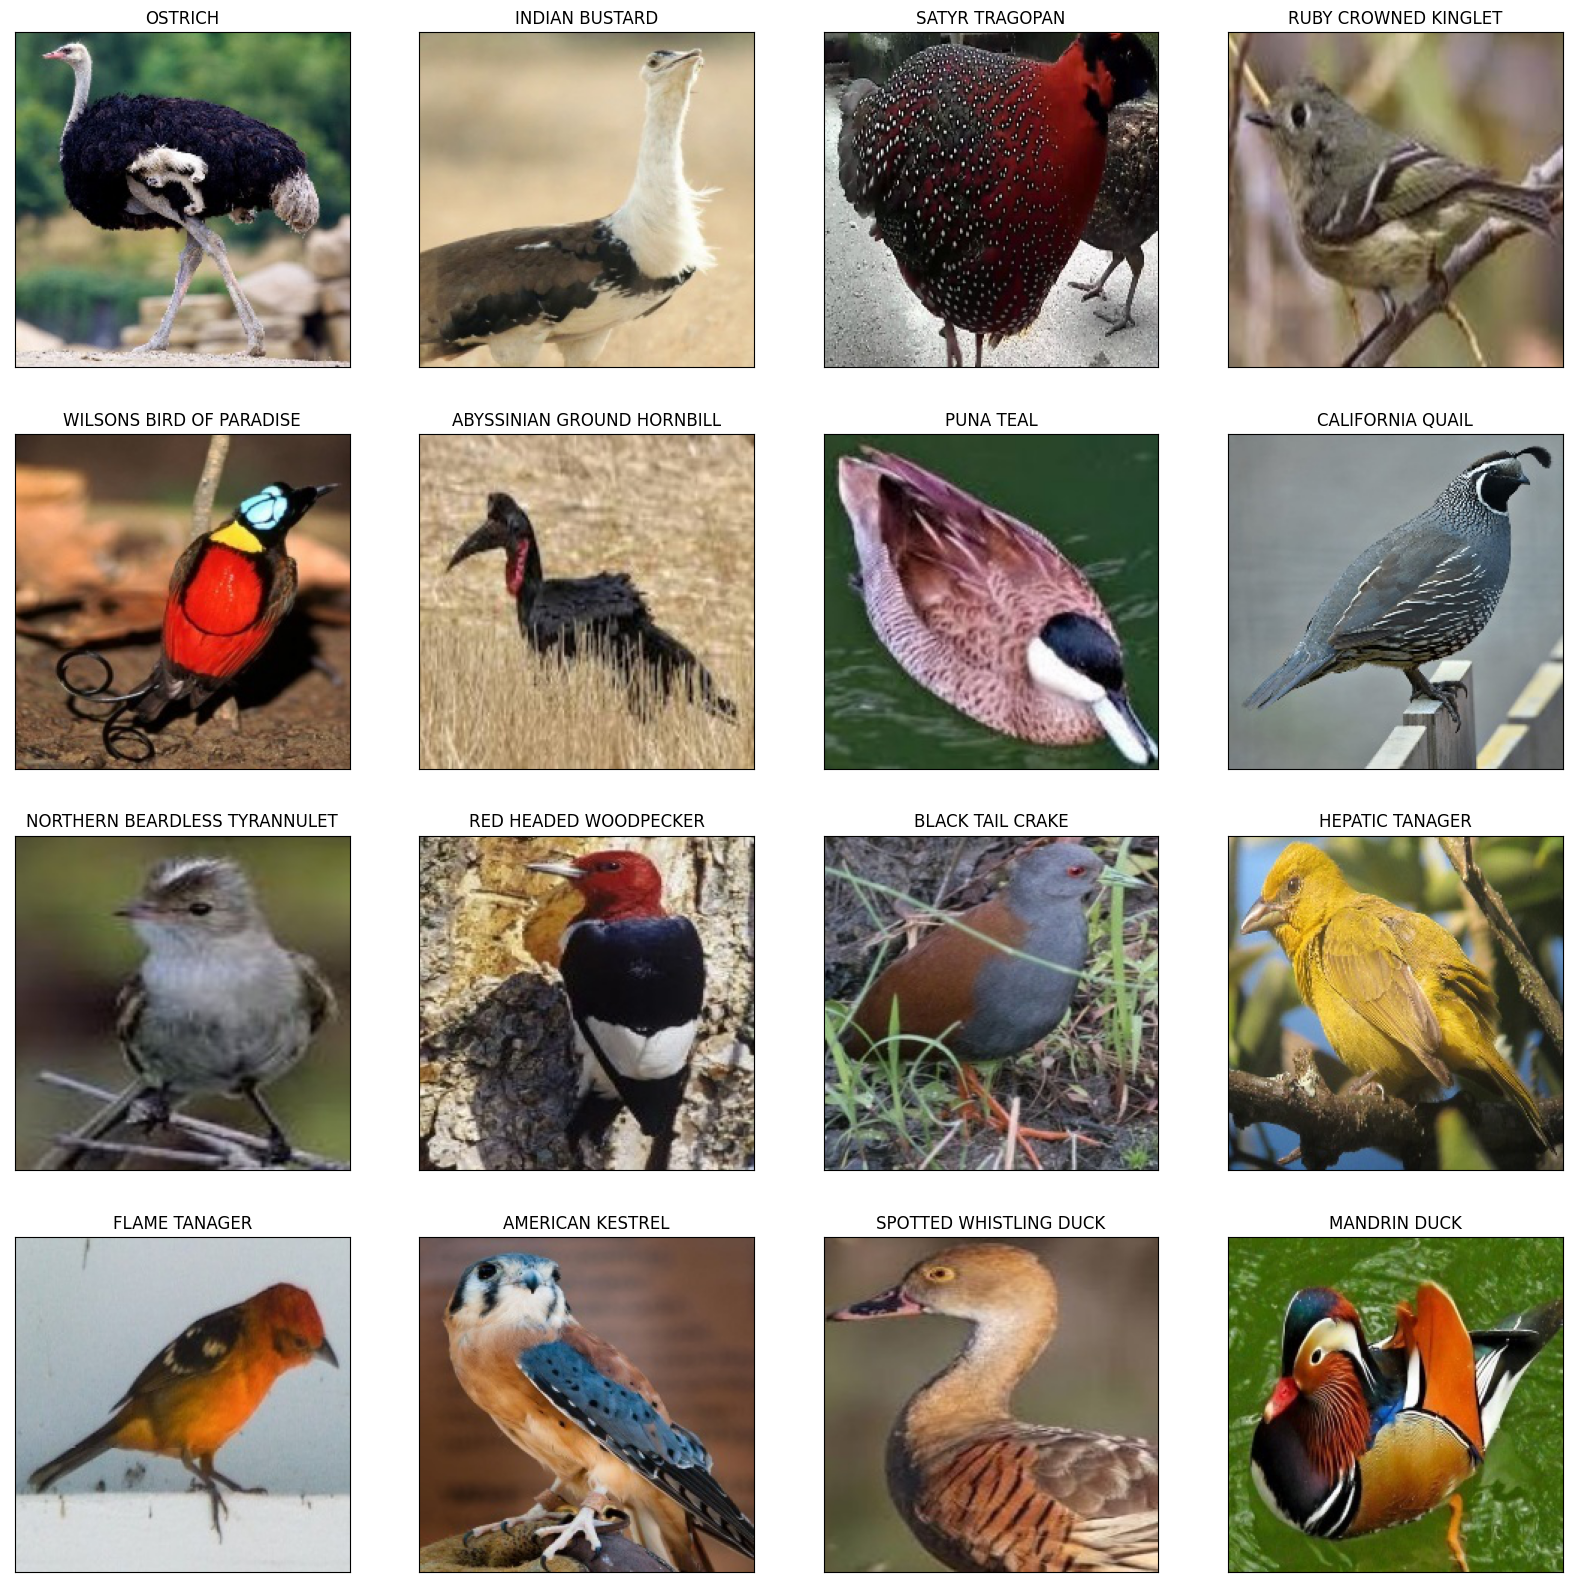

In [8]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i in range(16):
    axobject = axs[i // 4][i % 4]
    
    axobject.imshow(pixels[i].permute(1, 2, 0))
    axobject.set_title(species[labels.numpy()[i]])
    axobject.get_xaxis().set_visible(False)
    axobject.get_yaxis().set_visible(False)

Looks good, both the names and the images.

Now onto implementing the network.

## Network implementation

For this task I'll be implementing a ResNet network.

In [163]:
class ResNet(nn.Module):
    
    def __init__(self, n_labels):
        super(ResNet, self).__init__()
        
        self.base = nn.Conv2d(3, 64, (7, 7), stride=2, padding=3)
        self.pool = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)
        
        self.block1 = self.ResNetLayer(BottleneckBlock, 64, 256, 3)
        self.downsampling1 = nn.Conv2d(256, 128, (1, 1), stride=1)
        self.pooling1 = nn.MaxPool2d((3, 3), stride=2, padding=1)
        
        self.block2 = self.ResNetLayer(BottleneckBlock, 128, 512, 4)
        self.downsampling2 = nn.Conv2d(512, 256, (1, 1), stride=1)
        self.pooling2 = nn.MaxPool2d((3, 3), stride=2, padding=1)
        
        self.block3 = self.ResNetLayer(BottleneckBlock, 256, 1024, 6)
        self.downsampling3 = nn.Conv2d(1024, 512, (1, 1), stride=1)
        self.pooling3 = nn.MaxPool2d((3, 3), stride=2, padding=1)
        
        self.block4 = self.ResNetLayer(BottleneckBlock, 512, 2048, 3)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(2048, n_labels)
        
    
    def forward(self, x):
        
        x = self.base(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        
        x = self.block1(x)
        x = self.downsampling1(x)
        x = self.pooling1(x)
        
        x = self.block2(x)
        x = self.downsampling2(x)
        x = self.pooling2(x)
        
        x = self.block3(x)
        x = self.downsampling3(x)
        x = self.pooling3(x)
        
        x = self.block4(x)
        
        x = self.avgpool(x)
        x = nn.Flatten()(x)
        x = self.linear(x)
        x = nn.Softmax(dim=1)(x)
        
        return x
    
    
    def ResNetLayer(self, block, input_channels, output_channels, repetitions):
        
        layer = nn.Sequential()
        
        for i in range(repetitions - 1):
            layer.append(block(input_channels, output_channels))
            ## Downsampling back to the input dimensions
            layer.append(nn.Conv2d(output_channels, input_channels, (1, 1), stride=1))
        
        ## Last block without downsampling
        layer.append(block(input_channels, output_channels))
        
        return layer

In [69]:
class BottleneckBlock(nn.Module):
    
    def __init__(self, input_channels, output_channels):
        super(BottleneckBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        
        self.layer1 = nn.Conv2d(input_channels, input_channels, (1, 1), stride=1)
        self.layer2 = nn.Conv2d(input_channels, input_channels, (3, 3), stride=1, padding=1)
        self.layer3 = nn.Conv2d(input_channels, output_channels, (1, 1), stride=1)
        self.residual = nn.Conv2d(input_channels, output_channels, (1, 1), stride=1)
        
        
    def forward(self, x):
        
        x_init = x
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x += self.residual(x_init)
        x = nn.ReLU()(x)
        
        return x
    

In [162]:
ResNet(n_labels=525).forward(pixels)

torch.Size([16, 525])


tensor([[0.0019, 0.0019, 0.0020,  ..., 0.0019, 0.0019, 0.0019],
        [0.0019, 0.0019, 0.0020,  ..., 0.0019, 0.0019, 0.0019],
        [0.0019, 0.0019, 0.0020,  ..., 0.0019, 0.0019, 0.0019],
        ...,
        [0.0019, 0.0019, 0.0020,  ..., 0.0019, 0.0019, 0.0019],
        [0.0019, 0.0019, 0.0020,  ..., 0.0019, 0.0019, 0.0019],
        [0.0019, 0.0019, 0.0020,  ..., 0.0019, 0.0019, 0.0019]],
       grad_fn=<SoftmaxBackward0>)